In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych
X_train = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_train_labels.txt', header=None)
X_test = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_test_labels.txt', header=None)

# Połączenie features z etykietami
data = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)
data_all = pd.concat([data, data_test], axis=0)
data_all.columns = [*[f'feature_{i}' for i in range(561)], 'label']

data = data_all
print("Kształt danych:", data_all.shape)
print("\nRozkład klas:")
print(data['label'].value_counts())


C:\Users\wista\AppData\Local\Temp\ipykernel_6004\759494264.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_train.txt', delim_whitespace=True, header=None)
C:\Users\wista\AppData\Local\Temp\ipykernel_6004\759494264.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_test.txt', delim_whitespace=True, header=None)


Kształt danych: (10299, 562)

Rozkład klas:
label
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64


In [2]:
# Funkcja do oceny jakości klastrów
def evaluate_clustering(X, labels_true, labels_pred):
    silhouette = silhouette_score(X, labels_pred)
    ari = adjusted_rand_score(labels_true, labels_pred)
    return silhouette, ari

# 1. K-means
def kmeans_analysis(X, y_true, n_clusters=6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pred = kmeans.fit_predict(X)
    silhouette, ari = evaluate_clustering(X, y_true, labels_pred)
    return labels_pred, silhouette, ari

# 2. DBSCAN
def dbscan_analysis(X, y_true, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_pred = dbscan.fit_predict(X)
    # Pomijamy punkty oznaczone jako szum (-1) przy obliczaniu metryk
    mask = labels_pred != -1

     # Sprawdzamy liczbę unikalnych klastrów (bez szumu -1)
    n_clusters = len(np.unique(labels_pred[mask]))
    
    if sum(mask) > 0 and n_clusters > 1:
        silhouette = silhouette_score(X[mask], labels_pred[mask])
        ari = adjusted_rand_score(y_true[mask], labels_pred[mask])
    else:
        silhouette, ari = 0, 0
    return labels_pred, silhouette, ari

# 3. Gaussian Mixture Model
def gmm_analysis(X, y_true, n_components=6):
    gmm = GaussianMixture(n_components=n_components, random_state=42, covariance_type='tied', n_init=10)
    labels_pred = gmm.fit_predict(X)
    silhouette, ari = evaluate_clustering(X, y_true, labels_pred)
    return labels_pred, silhouette, ari

# 4. K-fold cross validation dla K-means
def kmeans_kfold(X, y, n_splits=5, n_clusters=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        labels_pred = kmeans.predict(X_val)
        
        silhouette = silhouette_score(X_val, labels_pred)
        ari = adjusted_rand_score(y_val, labels_pred)
        scores.append((silhouette, ari))
    
    return np.mean(scores, axis=0)



# Przeprowadzenie analiz

In [3]:


import pandas as pd
from scipy import stats

# Przygotowanie danych
X = data.iloc[:, :-1].values  # wszystkie cechy oprócz etykiety
y = data['label'].values

# Przygotowanie listy nazw cech
features = [f'feature_{i}' for i in range(561)]

# Obliczenie korelacji punktowo-biserialnej dla każdej cechy
corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(data[col], data['label'])[0]

# Sortowanie wyników i wyświetlenie top 10 najbardziej skorelowanych cech
correlations = pd.Series(corr_dict).sort_values(ascending=False)
print("Top 10 najbardziej skorelowanych cech:")
print(correlations.head(10))

# Wybór cech z korelacją większą niż 0.5
highly_correlated_features = correlations[correlations > 0.5]
print(f"\nLiczba cech z korelacją > 0.5: {len(highly_correlated_features)}")

# Utworzenie nowego zbioru danych tylko z wysoko skorelowanymi cechami
X_selected = data[highly_correlated_features.index]

# Normalizacja danych
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)





Top 10 najbardziej skorelowanych cech:
feature_92     0.789135
feature_93     0.788146
feature_13     0.768218
feature_12     0.758697
feature_134    0.751712
feature_94     0.730085
feature_172    0.727726
feature_14     0.699322
feature_133    0.697153
feature_174    0.681217
dtype: float64

Liczba cech z korelacją > 0.5: 33


In [4]:

n_clusters_values = [2, 3, 4, 5, 6, 7, 8, 9]
results = []
print("Analiza K-means:")
for n_clusters in n_clusters_values:
    kmeans_labels, kmeans_silhouette, kmeans_ari = kmeans_analysis(X_scaled, y, n_clusters=n_clusters)
    results.append((n_clusters, kmeans_silhouette, kmeans_ari))

results_df = pd.DataFrame(results, columns=['n_clusters', 'silhouette', 'ari'])
results_df.sort_values(by='silhouette', ascending=False)
results_df

Analiza K-means:


,n_clusters,silhouette,ari
0,2,0.424982,0.315786
1,3,0.399620,0.467008
2,4,0.302463,0.434556
3,5,0.224233,0.453165
4,6,0.213750,0.386574
5,7,0.195160,0.370116
6,8,0.172624,0.373080
7,9,0.156548,0.354812


In [5]:

print("Analiza K-means:")
kmeans_labels, kmeans_silhouette, kmeans_ari = kmeans_analysis(X_scaled, y, n_clusters=6)
print(f"Silhouette score: {kmeans_silhouette:.3f}")
print(f"Adjusted Rand Index: {kmeans_ari:.3f}\n")


Analiza K-means:
Silhouette score: 0.214
Adjusted Rand Index: 0.387



## DBSCAN

In [6]:
eps_values = [0.0001,0.01, 0.1, 1, 50]
min_samples_values = [5, 10, 20, 50, 100]
results = []
print("Analiza DBSCAN:")
for eps in eps_values:
    for min_samples in min_samples_values:
        # print(f"eps: {eps}, min_samples: {min_samples}")
        dbscan_labels, dbscan_silhouette, dbscan_ari = dbscan_analysis(X_scaled, y, eps=eps, min_samples=min_samples)
        # print(f"Silhouette score: {dbscan_silhouette:.3f}")
        # print(f"Adjusted Rand Index: {dbscan_ari:.3f}")
        # print(f"Liczba wykrytych klastrów: {len(np.unique(dbscan_labels))}\n")
        results.append((eps, min_samples, dbscan_silhouette, dbscan_ari))
    #     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    #     labels_pred = dbscan.fit_predict(X_scaled)
    # # Pomijamy punkty oznaczone jako szum (-1) przy obliczaniu metryk
    #     mask = labels_pred != -1
    #     if sum(mask) > 0:
    #         silhouette = silhouette_score(X_scaled[mask], labels_pred[mask])
    #         ari = adjusted_rand_score(y_dbscan[mask], labels_pred[mask])
    #     else:
    #         silhouette, ari = 0, 0

results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette', 'ari'])
results_df.sort_values(by='silhouette', ascending=False)
results_df

Analiza DBSCAN:


,eps,min_samples,silhouette,ari
0,0.0001,5,0.000000,0.000000
1,0.0001,10,0.000000,0.000000
2,0.0001,20,0.000000,0.000000
3,0.0001,50,0.000000,0.000000
4,0.0001,100,0.000000,0.000000
5,0.0100,5,0.000000,0.000000
6,0.0100,10,0.000000,0.000000
7,0.0100,20,0.000000,0.000000
8,0.0100,50,0.000000,0.000000
9,0.0100,100,0.000000,0.000000


In [14]:

print("Analiza DBSCAN:")
dbscan_labels, dbscan_silhouette, dbscan_ari = dbscan_analysis(X_scaled, y, eps=1, min_samples=5)
print(f"Silhouette score: {dbscan_silhouette:.3f}")
print(f"Adjusted Rand Index: {dbscan_ari:.3f}")
print(f"Liczba wykrytych klastrów: {len(np.unique(dbscan_labels))}\n")


Analiza DBSCAN:
Silhouette score: 0.020
Adjusted Rand Index: 0.306
Liczba wykrytych klastrów: 41



## GMM

In [8]:
n_components_values = [2, 3, 4, 5, 6, 7, 8, 9]
results = []
print("Analiza GMM:")
for n_components in n_components_values:
    gmm_labels, gmm_silhouette, gmm_ari = gmm_analysis(X_scaled, y, n_components=n_components)
    results.append((n_components, gmm_silhouette, gmm_ari))

results_df = pd.DataFrame(results, columns=['n_components', 'silhouette', 'ari'])
results_df.sort_values(by='silhouette', ascending=False)
results_df

Analiza GMM:


,n_components,silhouette,ari
0,2,0.421723,0.331451
1,3,0.394231,0.507424
2,4,0.379607,0.451366
3,5,0.256324,0.459935
4,6,0.216935,0.448671
5,7,0.236049,0.424472
6,8,0.119370,0.430193
7,9,0.127584,0.426814


In [9]:
print("Analiza GMM:")
gmm_labels, gmm_silhouette, gmm_ari = gmm_analysis(X_scaled, y, n_components=6)
print(f"Silhouette score: {gmm_silhouette:.3f}")
print(f"Adjusted Rand Index: {gmm_ari:.3f}\n")

Analiza GMM:
Silhouette score: 0.217
Adjusted Rand Index: 0.449



## Kfold

In [10]:
n_splits_values = [2, 3, 4, 5, 6, 7, 8, 9]
results = []
for n_splits in n_splits_values:
    kfold_silhouette, kfold_ari = kmeans_kfold(X_scaled, y, n_splits=n_splits)
    results.append((n_splits, kfold_silhouette, kfold_ari))

results_df = pd.DataFrame(results, columns=['n_splits', 'silhouette', 'ari'])
results_df.sort_values(by='silhouette', ascending=False)
results_df

,n_splits,silhouette,ari
0,2,0.212582,0.386095
1,3,0.197503,0.435650
2,4,0.218074,0.422983
3,5,0.211837,0.402544
4,6,0.209098,0.411200
5,7,0.200594,0.430913
6,8,0.209379,0.425202
7,9,0.205013,0.434825


In [11]:
print("K-fold cross validation dla K-means:")
kfold_silhouette, kfold_ari = kmeans_kfold(X_scaled, y, 6)
print(f"Średni Silhouette score: {kfold_silhouette:.3f}")
print(f"Średni Adjusted Rand Index: {kfold_ari:.3f}")

K-fold cross validation dla K-means:
Średni Silhouette score: 0.209
Średni Adjusted Rand Index: 0.411


Wizualizacja wyników dla każdej metody (PCA)


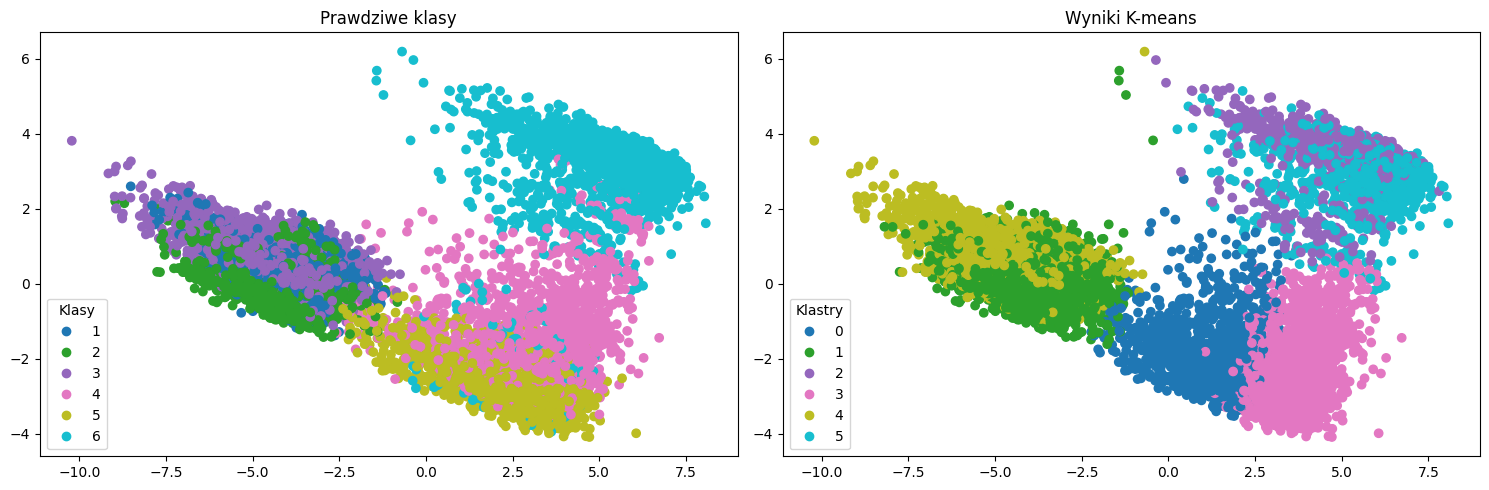

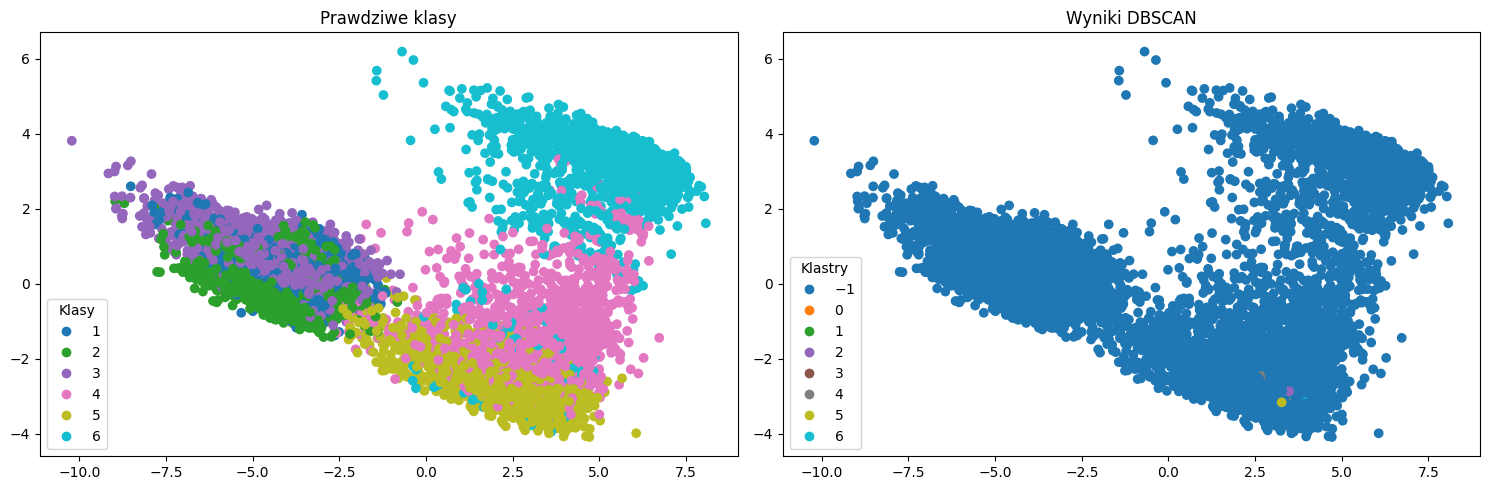

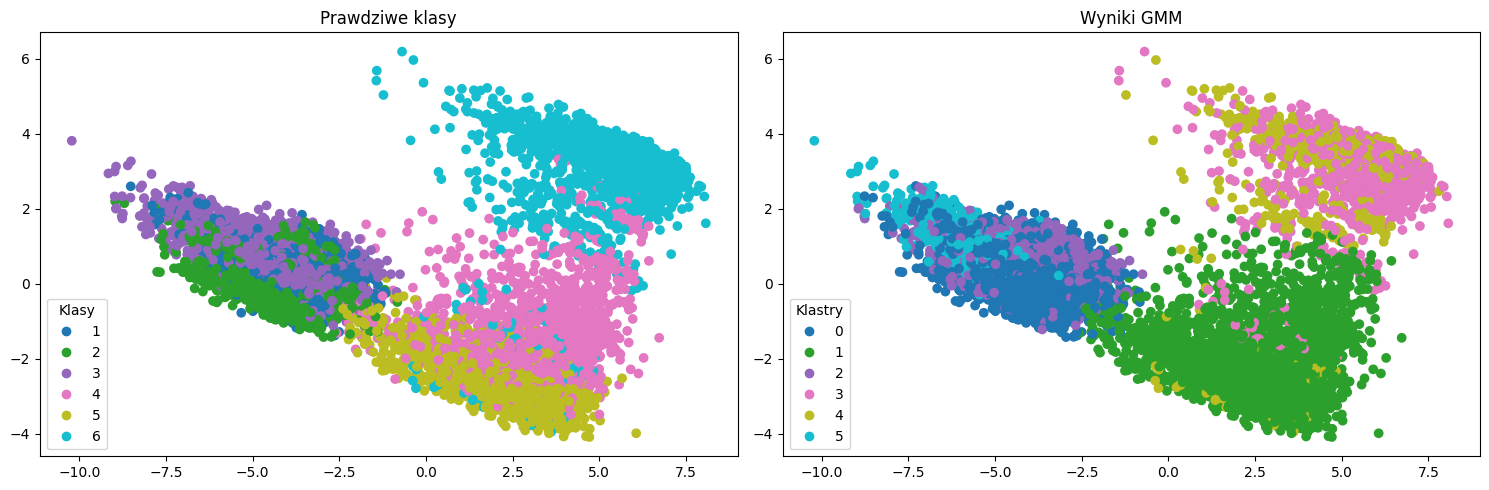

Wizualizacja wyników dla każdej metody (T-SNE)


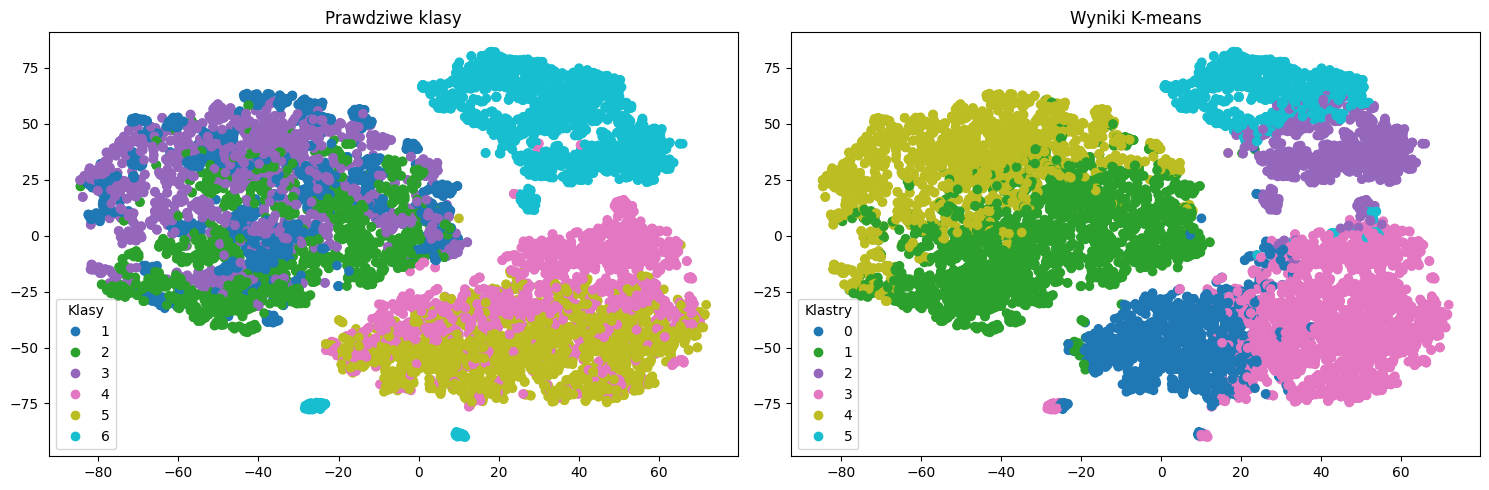

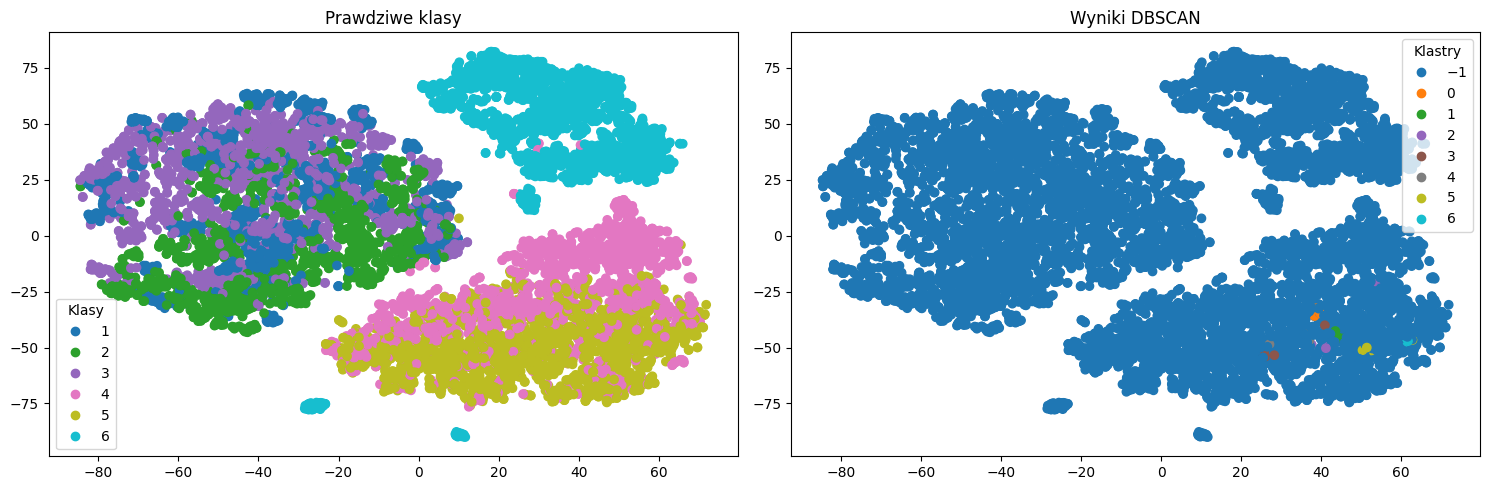

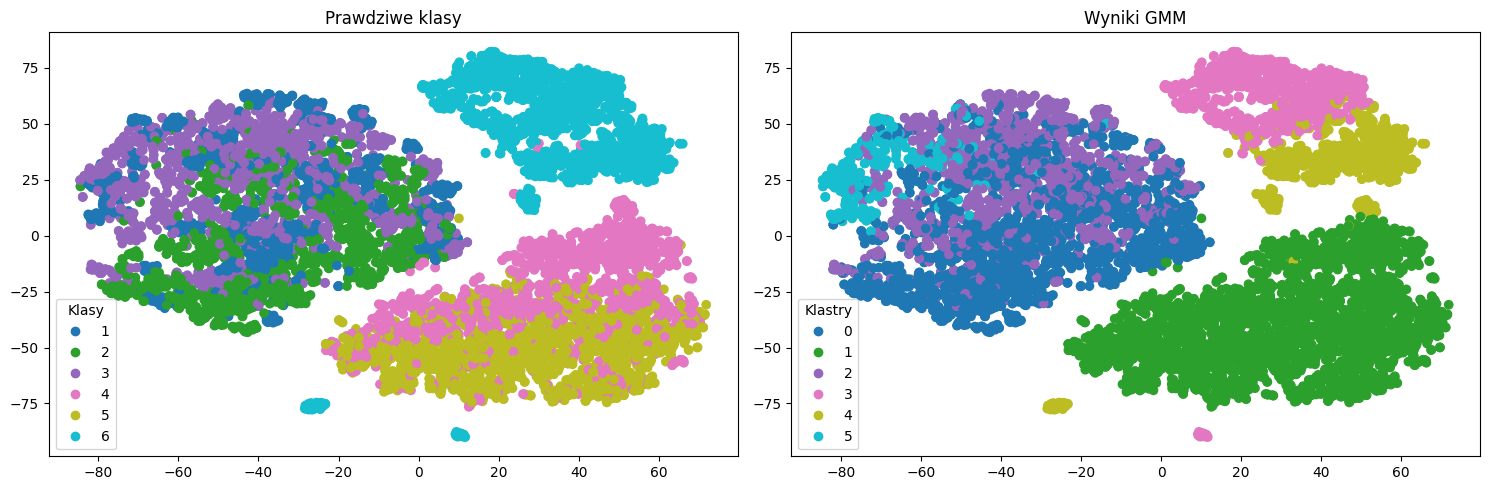

In [12]:
# Wizualizacja wyników przy użyciu t-SNE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Redukcja wymiarowości do 2D dla wizualizacji
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Funkcja do tworzenia wykresów
def plot_clustering_results(X_2d, true_labels, pred_labels, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Prawdziwe etykiety
    scatter1 = ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=true_labels, cmap='tab10')
    ax1.set_title('Prawdziwe klasy')
    ax1.legend(*scatter1.legend_elements(), title="Klasy")
    
    # Przewidziane klastry
    scatter2 = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=pred_labels, cmap='tab10')
    ax2.set_title(f'Wyniki {title}')
    ax2.legend(*scatter2.legend_elements(), title="Klastry")
    
    plt.tight_layout()
    plt.show()

# Wizualizacja wyników dla każdej metody
print("Wizualizacja wyników dla każdej metody (PCA)")
plot_clustering_results(X_pca, y, kmeans_labels, "K-means")
plot_clustering_results(X_pca, y, dbscan_labels, "DBSCAN")
plot_clustering_results(X_pca, y, gmm_labels, "GMM")
print("Wizualizacja wyników dla każdej metody (T-SNE)")
plot_clustering_results(X_tsne, y, kmeans_labels, "K-means")
plot_clustering_results(X_tsne, y, dbscan_labels, "DBSCAN")
plot_clustering_results(X_tsne, y, gmm_labels, "GMM")



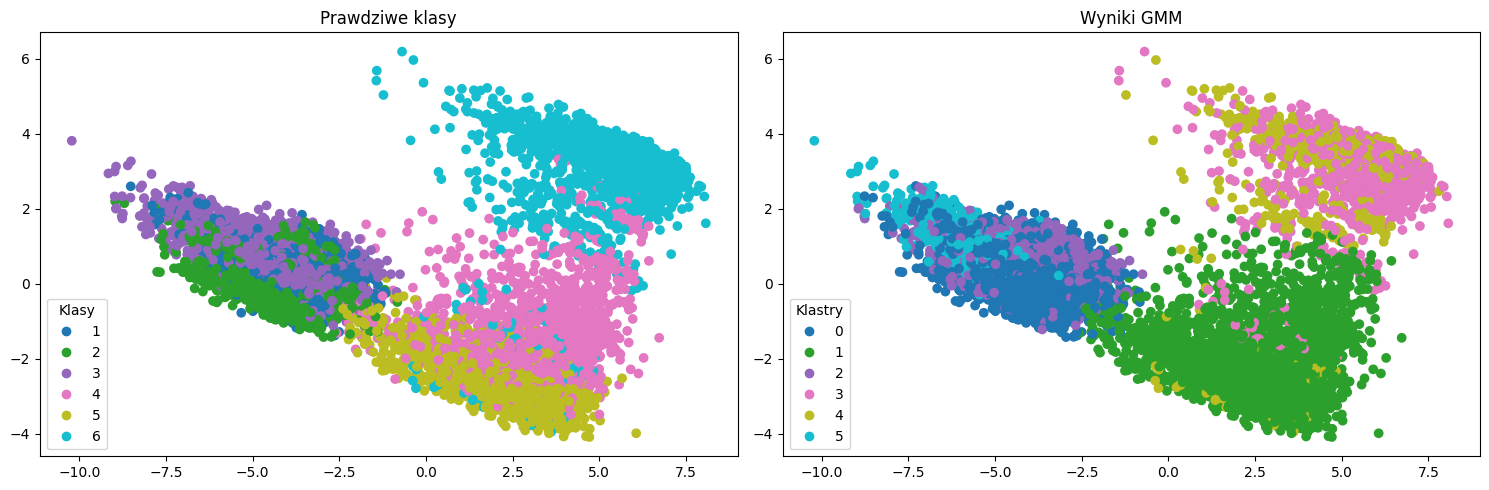

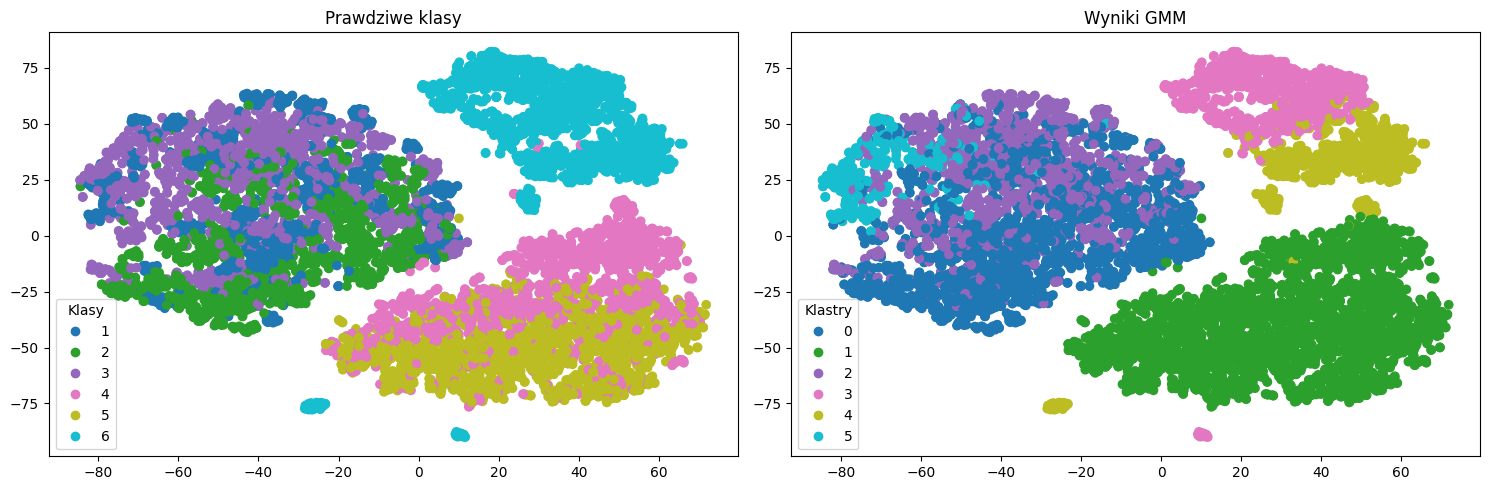

In [13]:

plot_clustering_results(X_pca, y, gmm_labels, "GMM")
plot_clustering_results(X_tsne, y, gmm_labels, "GMM")